# Greedy Waypoint Visualization

Load the 12x12 grid with multiple shapes and visualize trajectories using greedy nearest-neighbor waypoint selection.

In [1]:
# Setup
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from utils.grid_integration import load_and_build_env

## Load 12x12 Grid with Greedy Waypoint Selection

In [2]:
# Load grid with greedy waypoint selection enabled
json_path = Path.cwd() / "grid-150x150(3).json"

sector_env, attackers, grid_data = load_and_build_env(
    json_path,
    default_drone_speed=50.0,
    use_centroid_as_waypoint=True,
    use_shape_centroids_as_waypoints=True  # Enable greedy nearest-neighbor
)

print(f"Grid: {sector_env.width}×{sector_env.height} cells @ {sector_env.cell_size}m/cell")
print(f"Shapes: {len(grid_data.shapes)}")
print(f"Attackers: {len(attackers)}")

# Show shape centroids
print(f"\nShape centroids (waypoints):")
for i, shape in enumerate(grid_data.shapes, 1):
    print(f"  Shape {i}: {tuple(shape.centroid_meters)}")

Grid: 150×150 cells @ 100.0m/cell
Shapes: 2
Attackers: 4

Shape centroids (waypoints):
  Shape 1: (4866.666666666666, 11066.666666666666)
  Shape 2: (10666.666666666668, 3266.666666666668)


## Visualize All Trajectories

Use the environment's built-in `visualize_trajectories()` method.

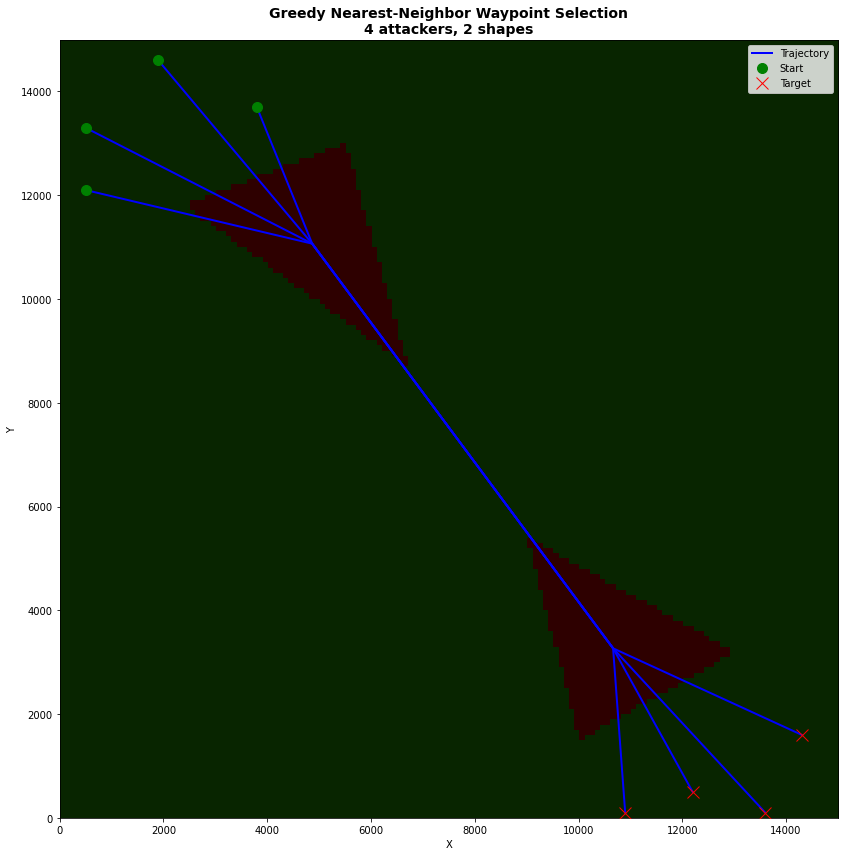

In [3]:
# Visualize all trajectories using environment method
fig, ax = plt.subplots(figsize=(12, 12))
sector_env.visualize_trajectories(ax=ax, show=False, show_sectors=True, show_heatmap=False)
ax.set_title(f'Greedy Nearest-Neighbor Waypoint Selection\n{len(attackers)} attackers, {len(grid_data.shapes)} shapes', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Waypoint Analysis

Show how each attacker chose their waypoint order.

In [4]:
print("=" * 70)
print("GREEDY WAYPOINT SELECTION ANALYSIS")
print("=" * 70)

# Get available shape centroids
shape_centroids = [tuple(shape.centroid_meters) for shape in grid_data.shapes]
print(f"\nAvailable shape centroids:")
for i, centroid in enumerate(shape_centroids, 1):
    print(f"  Shape {i}: {centroid}")

# Analyze each attacker's waypoint choices
for i, attacker in enumerate(attackers, 1):
    print(f"\n{'-' * 70}")
    print(f"Attacker {i}:")
    print(f"  Start: {attacker.start_position}")
    print(f"  Target: {attacker.target_position}")
    print(f"  Waypoints: {attacker.waypoints}")
    
    if attacker.waypoints:
        # Calculate path segments
        print(f"\n  Path analysis:")
        current_pos = np.array(attacker.start_position)
        
        # Start to first waypoint
        wp1 = np.array(attacker.waypoints[0])
        dist = np.linalg.norm(wp1 - current_pos)
        print(f"    Start → Waypoint 1: {dist:.2f}m")
        current_pos = wp1
        
        # Between waypoints
        for j in range(1, len(attacker.waypoints)):
            wp = np.array(attacker.waypoints[j])
            dist = np.linalg.norm(wp - current_pos)
            print(f"    Waypoint {j} → Waypoint {j+1}: {dist:.2f}m")
            current_pos = wp
        
        # Last waypoint to target
        target = np.array(attacker.target_position)
        dist = np.linalg.norm(target - current_pos)
        print(f"    Waypoint {len(attacker.waypoints)} → Target: {dist:.2f}m")
        
        # Total distance
        total_with_waypoints = sum(
            np.linalg.norm(
                np.array(attacker.trajectory[i+1]) - np.array(attacker.trajectory[i])
            )
            for i in range(len(attacker.trajectory) - 1)
        )
        direct_distance = np.linalg.norm(target - np.array(attacker.start_position))
        
        print(f"\n  Total path length: {total_with_waypoints:.2f}m")
        print(f"  Direct distance: {direct_distance:.2f}m")
        print(f"  Detour factor: {total_with_waypoints / direct_distance:.2f}x")

print("\n" + "=" * 70)

GREEDY WAYPOINT SELECTION ANALYSIS

Available shape centroids:
  Shape 1: (4866.666666666666, 11066.666666666666)
  Shape 2: (10666.666666666668, 3266.666666666668)

----------------------------------------------------------------------
Attacker 1:
  Start: (500.0, 13300.0)
  Target: (14300.0, 1600.0)
  Waypoints: [(4866.666666666666, 11066.666666666666), (10666.666666666668, 3266.666666666668)]

  Path analysis:
    Start → Waypoint 1: 4904.65m
    Waypoint 1 → Waypoint 2: 9720.08m
    Waypoint 2 → Target: 3997.36m

  Total path length: 18622.09m
  Direct distance: 18092.26m
  Detour factor: 1.03x

----------------------------------------------------------------------
Attacker 2:
  Start: (3800.0, 13700.0)
  Target: (13600.0, 100.0)
  Waypoints: [(4866.666666666666, 11066.666666666666), (10666.666666666668, 3266.666666666668)]

  Path analysis:
    Start → Waypoint 1: 2841.17m
    Waypoint 1 → Waypoint 2: 9720.08m
    Waypoint 2 → Target: 4316.51m

  Total path length: 16877.75m
  Dir

### Visualize without detectors:

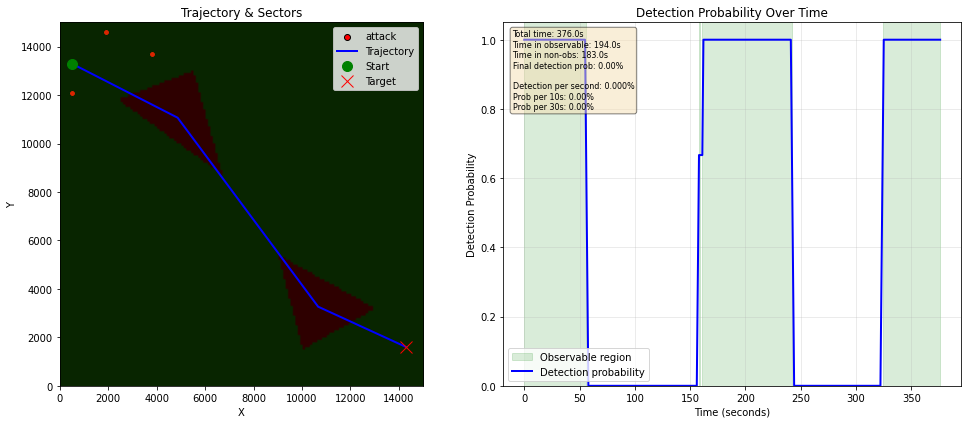

In [5]:
# Detailed analysis with plots for first attacker
if len(attackers) > 0:
    sector_env.visualize_trajectory_analysis(attackers[0], figsize=(14, 6))

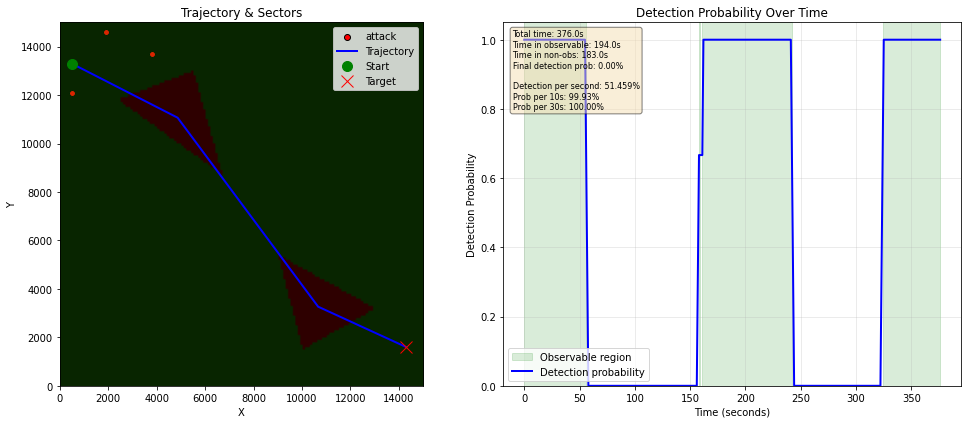

In [6]:
# Detailed analysis with plots for first attacker
if len(attackers) > 0:
    sector_env.visualize_trajectory_analysis(attackers[0], figsize=(14, 6), include_observable_in_stats=True)

### Visualize without detectors

**Note:** The visualization always shows the trajectory with green shading for observable regions and the actual detector probabilities in non-observable regions. The statistical analysis can optionally include or exclude observable time from calculations.

**How Detection Probability is Calculated:**

The `analyze_trajectory()` function now has a parameter `include_observable_in_stats`:

**When `include_observable_in_stats=False` (default):**
- Observable regions are **EXCLUDED** from all statistics
- Only non-observable time counts
- Formula: `avg = sum(detector_probs in non-obs) / time_in_nonobs`

**When `include_observable_in_stats=True`:**
- Observable regions are **INCLUDED** as 100% detection
- Total flight time used in calculations
- Formula: `avg = (sum(detector_probs in non-obs) + time_in_obs × 1.0) / total_time`

Place detectors in the non-observable region for detection analysis.

In [7]:
from configs import detector_configs
from src.detectors import Rect_Detectors

# Clear existing detectors
sector_env.detectors = []

# Find non-observable region bounds
non_obs_cells = np.argwhere(~sector_env.observable_mask)

if len(non_obs_cells) > 0:
    # Get bounding box
    y_min, x_min = non_obs_cells.min(axis=0)
    y_max, x_max = non_obs_cells.max(axis=0)
    
    # Convert to meters
    x_min_m = x_min * sector_env.cell_size
    y_min_m = y_min * sector_env.cell_size
    x_max_m = (x_max + 1) * sector_env.cell_size
    y_max_m = (y_max + 1) * sector_env.cell_size
    
    # Place detectors with inset
    inset = sector_env.cell_size * 2
    detector_corners = [
        (x_min_m + inset, y_min_m + inset),
        (x_max_m - inset, y_min_m + inset),
        (x_max_m - inset, y_max_m - inset),
        (x_min_m + inset, y_max_m - inset),
    ]
    
    # Calculate spacing
    width_m = x_max_m - x_min_m
    spacing = 3* max(width_m / 8, sector_env.cell_size * 3)
    
    # Create detectors with custom radius (change radius here!)
    detector_type = detector_configs.DetectorType.VISUAL
    detectors = Rect_Detectors(
        detector_type,
        detector_corners,
        spacing=spacing
    )
    
    # Add to environment
    for det in detectors:
        sector_env.add_detector(det)
    
    print(f"✅ Added {len(detectors)} {detector_type.value} detectors")
    print(f"Spacing: {spacing:.0f}m")
    print(f"Detector radius: {detectors[0].radius:.0f}m")
    print(f"Non-observable region: {x_min_m:.0f}m-{x_max_m:.0f}m × {y_min_m:.0f}m-{y_max_m:.0f}m")
else:
    print("⚠️ No non-observable region found!")

✅ Added 9 visual detectors
Spacing: 3900m
Detector radius: 1500m
Non-observable region: 2500m-12900m × 1500m-13000m


## Visualize with Detectors

Show trajectories with detector coverage zones.

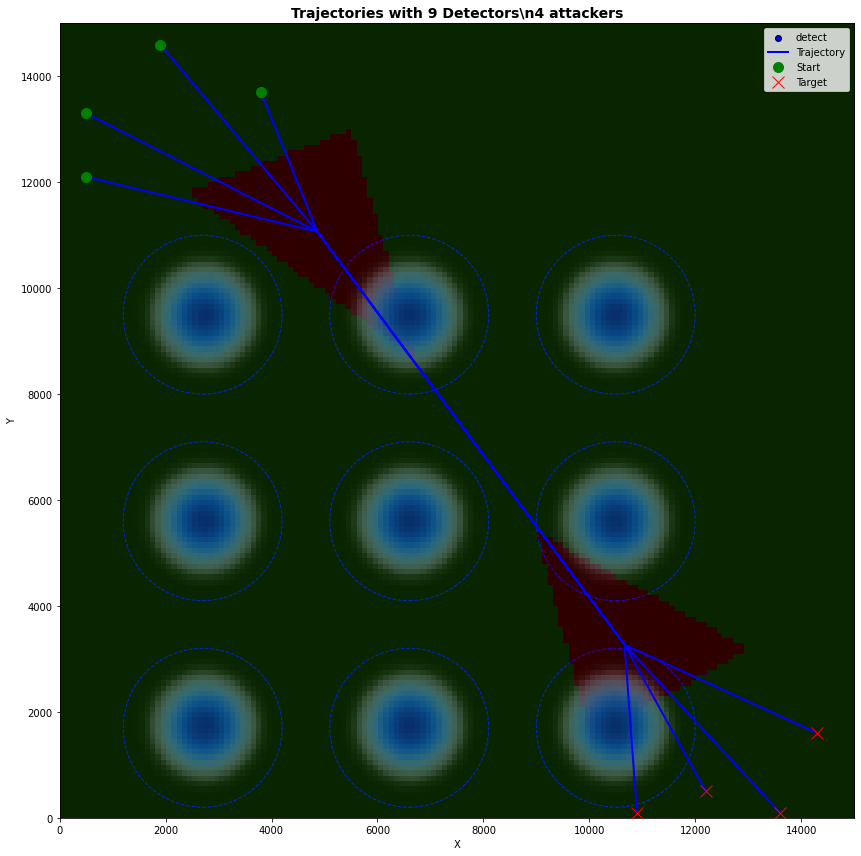

In [8]:
# Visualize trajectories with detection zones
fig, ax = plt.subplots(figsize=(12, 12))
sector_env.visualize_trajectories(ax=ax, show=False, show_sectors=True, show_heatmap=True)
ax.set_title(f'Trajectories with {len(sector_env.detectors)} Detectors\\n{len(attackers)} attackers', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Statistical Analysis

Analyze detection probability for each attacker trajectory.

In [9]:
print("=" * 70)
print("DETECTION PROBABILITY ANALYSIS")
print("=" * 70)
print(f"Detector Configuration: {len(sector_env.detectors)} detectors")
print(f"Detector Type: VISUAL")
print(f"Detector Radius: {sector_env.detectors[0].radius:.0f}m")
print("")

# Set this variable to control whether observable regions are included
INCLUDE_OBSERVABLE_IN_STATS = False  # Change to True to include green regions

print(f"📊 Analysis mode: {'INCLUDING' if INCLUDE_OBSERVABLE_IN_STATS else 'EXCLUDING'} observable regions")
print("")

# Analyze each attacker
for i, attacker in enumerate(attackers, 1):
    analysis = sector_env.analyze_trajectory(
        attacker.trajectory,
        time_per_step=1.0,
        only_nonobservable=True,
        include_observable_in_stats=INCLUDE_OBSERVABLE_IN_STATS
    )
    
    print(f"\n{'-' * 70}")
    print(f"Attacker {i}:")
    print(f"  Start: {attacker.start_position}")
    print(f"  Target: {attacker.target_position}")
    print(f"  Waypoints: {len(attacker.waypoints) if attacker.waypoints else 0}")
    print(f"\n  Flight Statistics:")
    print(f"    Total flight time: {len(attacker.trajectory)}s ({len(attacker.trajectory)/60:.1f} min)")
    print(f"    Time in observable region: {analysis['time_in_observable']:.1f}s ({analysis['time_in_observable']/len(attacker.trajectory)*100:.1f}%)")
    print(f"    Time in non-observable region: {analysis['time_in_nonobservable']:.1f}s ({analysis['time_in_nonobservable']/len(attacker.trajectory)*100:.1f}%)")
    
    print(f"\n  Detection Statistics:")
    print(f"    Cumulative detection probability: {analysis['cumulative_detection_prob']:.2%}")
    print(f"    Average detection per second: {analysis['avg_detection_per_second']:.4%}")
    print(f"    Detection probability per 10s: {analysis['detection_rate_per_interval']['10s']:.2%}")
    print(f"    Detection probability per 30s: {analysis['detection_rate_per_interval']['30s']:.2%}")
    print(f"    Detection probability per 60s: {analysis['detection_rate_per_interval']['60s']:.2%}")
    
    print(f"\n  Gap Coverage (Statistical Model):")
    print(f"    Probability NO gap > 5s: {analysis['max_undetected_gap']['5s']:.2%}")
    print(f"    Probability NO gap > 10s: {analysis['max_undetected_gap']['10s']:.2%}")
    print(f"    Probability NO gap > 30s: {analysis['max_undetected_gap']['30s']:.2%}")
    print(f"    Probability NO gap > 60s: {analysis['max_undetected_gap']['60s']:.2%}")
    
    print(f"\n  Sliding Window Analysis (Actual):")
    sw = analysis['sliding_window_stats']['summary']
    if '5s' in sw:
        print(f"    5s windows  - Min: {sw['5s']['min']:.2%}, Max: {sw['5s']['max']:.2%}, Mean: {sw['5s']['mean']:.2%}")
    if '10s' in sw:
        print(f"    10s windows - Min: {sw['10s']['min']:.2%}, Max: {sw['10s']['max']:.2%}, Mean: {sw['10s']['mean']:.2%}")
    if '30s' in sw:
        print(f"    30s windows - Min: {sw['30s']['min']:.2%}, Max: {sw['30s']['max']:.2%}, Mean: {sw['30s']['mean']:.2%}")
    if '60s' in sw:
        print(f"    60s windows - Min: {sw['60s']['min']:.2%}, Max: {sw['60s']['max']:.2%}, Mean: {sw['60s']['mean']:.2%}")
    
    if analysis['first_detection_time'] is not None:
        print(f"\n    First 50% detection at: {analysis['first_detection_time']:.1f}s")
    else:
        print(f"\n    First 50% detection: Never reached")

print("\n" + "=" * 70)

# Summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

cumulative_probs = [
    sector_env.analyze_trajectory(a.trajectory, 1.0, True, INCLUDE_OBSERVABLE_IN_STATS)['cumulative_detection_prob']
    for a in attackers
]

print(f"\nOverall Detection Statistics:")
print(f"  Mean cumulative detection prob: {np.mean(cumulative_probs):.2%}")
print(f"  Median cumulative detection prob: {np.median(cumulative_probs):.2%}")
print(f"  Min cumulative detection prob: {np.min(cumulative_probs):.2%}")
print(f"  Max cumulative detection prob: {np.max(cumulative_probs):.2%}")
print(f"  Std dev: {np.std(cumulative_probs):.2%}")

print("\n" + "=" * 70)


DETECTION PROBABILITY ANALYSIS
Detector Configuration: 9 detectors
Detector Type: VISUAL
Detector Radius: 1500m

📊 Analysis mode: EXCLUDING observable regions


----------------------------------------------------------------------
Attacker 1:
  Start: (500.0, 13300.0)
  Target: (14300.0, 1600.0)
  Waypoints: 2

  Flight Statistics:
    Total flight time: 377s (6.3 min)
    Time in observable region: 194.0s (51.5%)
    Time in non-observable region: 183.0s (48.5%)

  Detection Statistics:
    Cumulative detection probability: 100.00%
    Average detection per second: 10.8477%
    Detection probability per 10s: 68.28%
    Detection probability per 30s: 96.81%
    Detection probability per 60s: 99.90%

  Gap Coverage (Statistical Model):
    Probability NO gap > 5s: 0.00%
    Probability NO gap > 10s: 0.10%
    Probability NO gap > 30s: 82.32%
    Probability NO gap > 60s: 99.69%

  Sliding Window Analysis (Actual):
    5s windows  - Min: 0.00%, Max: 99.98%, Mean: 9.07%
    10s windows -

### Comparison: With vs Without Observable Regions

Compare detection statistics when including vs excluding observable regions in calculations.

In [ ]:
# Compare both calculation methods for first attacker
if len(attackers) > 0:
    attacker = attackers[0]
    
    # Without observable regions
    analysis_excl = sector_env.analyze_trajectory(
        attacker.trajectory,
        time_per_step=1.0,
        only_nonobservable=True,
        include_observable_in_stats=False
    )
    
    # With observable regions
    analysis_incl = sector_env.analyze_trajectory(
        attacker.trajectory,
        time_per_step=1.0,
        only_nonobservable=True,
        include_observable_in_stats=True
    )
    
    print("=" * 85)
    print("COMPARISON: EXCLUDING vs INCLUDING Observable Regions in Statistics")
    print("=" * 85)
    print(f"\n{'Metric':<45} {'EXCLUDING':<20} {'INCLUDING':<20}")
    print("-" * 85)
    print(f"{'Average detection per second:':<45} {analysis_excl['avg_detection_per_second']:>18.4%} {analysis_incl['avg_detection_per_second']:>18.4%}")
    print(f"{'Detection probability per 10s:':<45} {analysis_excl['detection_rate_per_interval']['10s']:>18.2%} {analysis_incl['detection_rate_per_interval']['10s']:>18.2%}")
    print(f"{'Detection probability per 30s:':<45} {analysis_excl['detection_rate_per_interval']['30s']:>18.2%} {analysis_incl['detection_rate_per_interval']['30s']:>18.2%}")
    print(f"{'Detection probability per 60s:':<45} {analysis_excl['detection_rate_per_interval']['60s']:>18.2%} {analysis_incl['detection_rate_per_interval']['60s']:>18.2%}")
    print(f"{'Cumulative detection (non-obs only):':<45} {analysis_excl['cumulative_detection_prob']:>18.2%} {analysis_incl['cumulative_detection_prob']:>18.2%}")
    print("-" * 85)
    
    print(f"\n{'Gap Coverage (Statistical Model):':<45}")
    print(f"{'  Probability NO gap > 5s:':<45} {analysis_excl['max_undetected_gap']['5s']:>18.2%} {analysis_incl['max_undetected_gap']['5s']:>18.2%}")
    print(f"{'  Probability NO gap > 10s:':<45} {analysis_excl['max_undetected_gap']['10s']:>18.2%} {analysis_incl['max_undetected_gap']['10s']:>18.2%}")
    print(f"{'  Probability NO gap > 30s:':<45} {analysis_excl['max_undetected_gap']['30s']:>18.2%} {analysis_incl['max_undetected_gap']['30s']:>18.2%}")
    print(f"{'  Probability NO gap > 60s:':<45} {analysis_excl['max_undetected_gap']['60s']:>18.2%} {analysis_incl['max_undetected_gap']['60s']:>18.2%}")
    print("-" * 85)
    
    print(f"\n{'Sliding Window Analysis (Min Detection):':<45}")
    sw_excl = analysis_excl['sliding_window_stats']['summary']
    sw_incl = analysis_incl['sliding_window_stats']['summary']
    if '5s' in sw_excl:
        print(f"{'  5-second windows:':<45} {sw_excl['5s']['min']:>18.2%} {sw_incl['5s']['min']:>18.2%}")
    if '10s' in sw_excl:
        print(f"{'  10-second windows:':<45} {sw_excl['10s']['min']:>18.2%} {sw_incl['10s']['min']:>18.2%}")
    if '30s' in sw_excl:
        print(f"{'  30-second windows:':<45} {sw_excl['30s']['min']:>18.2%} {sw_incl['30s']['min']:>18.2%}")
    if '60s' in sw_excl:
        print(f"{'  60-second windows:':<45} {sw_excl['60s']['min']:>18.2%} {sw_incl['60s']['min']:>18.2%}")
    
    print(f"\n{'Sliding Window Analysis (Mean Detection):':<45}")
    if '5s' in sw_excl:
        print(f"{'  5-second windows:':<45} {sw_excl['5s']['mean']:>18.2%} {sw_incl['5s']['mean']:>18.2%}")
    if '10s' in sw_excl:
        print(f"{'  10-second windows:':<45} {sw_excl['10s']['mean']:>18.2%} {sw_incl['10s']['mean']:>18.2%}")
    if '30s' in sw_excl:
        print(f"{'  30-second windows:':<45} {sw_excl['30s']['mean']:>18.2%} {sw_incl['30s']['mean']:>18.2%}")
    if '60s' in sw_excl:
        print(f"{'  60-second windows:':<45} {sw_excl['60s']['mean']:>18.2%} {sw_incl['60s']['mean']:>18.2%}")
    
    print("-" * 85)
    print(f"\n📊 Key Insights:")
    print(f"   - EXCLUDING: Only counts detector performance in red (non-observable) regions")
    print(f"   - INCLUDING: Treats green (observable) regions as 100% detection, averaging with red regions")
    print(f"   - Observable time: {analysis_excl['time_in_observable']:.1f}s ({analysis_excl['time_in_observable']/(analysis_excl['time_in_observable']+analysis_excl['time_in_nonobservable'])*100:.1f}%)")
    print(f"   - Non-observable time: {analysis_excl['time_in_nonobservable']:.1f}s ({analysis_excl['time_in_nonobservable']/(analysis_excl['time_in_observable']+analysis_excl['time_in_nonobservable'])*100:.1f}%)")
    print(f"\n📏 Metric Definitions:")
    print(f"   - 'Detection per Xs': Probability of being detected in ANY X-second window (exponential model)")
    print(f"   - 'Gap Coverage': Probability that we NEVER have a gap longer than X seconds (statistical)")
    print(f"   - 'Sliding Window Min': WORST X-second window detection (actual trajectory data)")
    print(f"   - 'Sliding Window Mean': AVERAGE X-second window detection (actual trajectory data)")
    print("=" * 85)


COMPARISON: EXCLUDING vs INCLUDING Observable Regions in Statistics

Metric                                        EXCLUDING            INCLUDING           
-------------------------------------------------------------------------------------
Average detection per second:                           11.8525%           57.2150%
Detection probability per 10s:                            71.68%             99.98%
Detection probability per 30s:                            97.73%            100.00%
Detection probability per 60s:                            99.95%            100.00%
Cumulative detection (non-obs only):                     100.00%            100.00%
-------------------------------------------------------------------------------------

Gap Coverage (Statistical Model):            
  Probability NO gap > 5s:                                 0.00%             62.09%
  Probability NO gap > 10s:                                0.49%             99.67%
  Probability NO gap > 30s:         

## Detailed Trajectory Analysis

Visual analysis of detection probability over time for the first attacker.

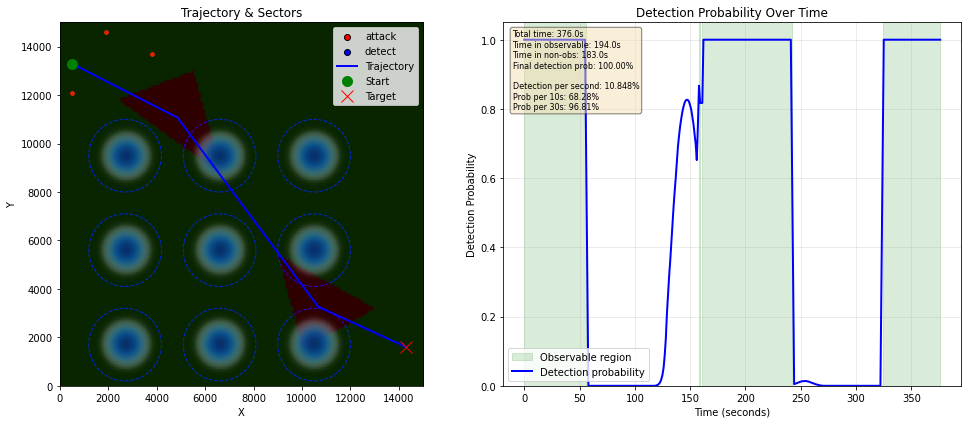

In [11]:
# Detailed analysis with plots for first attacker
if len(attackers) > 0:
    sector_env.visualize_trajectory_analysis(attackers[0], figsize=(14, 6))

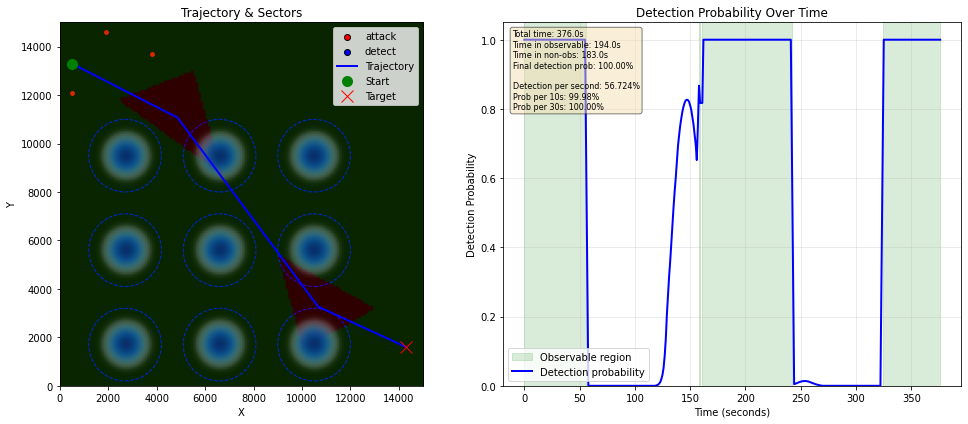

In [12]:
# Detailed analysis with plots for first attacker
if len(attackers) > 0:
    sector_env.visualize_trajectory_analysis(attackers[0], figsize=(14, 6), include_observable_in_stats=True)

### Visual Comparison: Both Calculation Methods

Compare the probability plots with both calculation methods.

EXCLUDING Observable Regions from Statistics


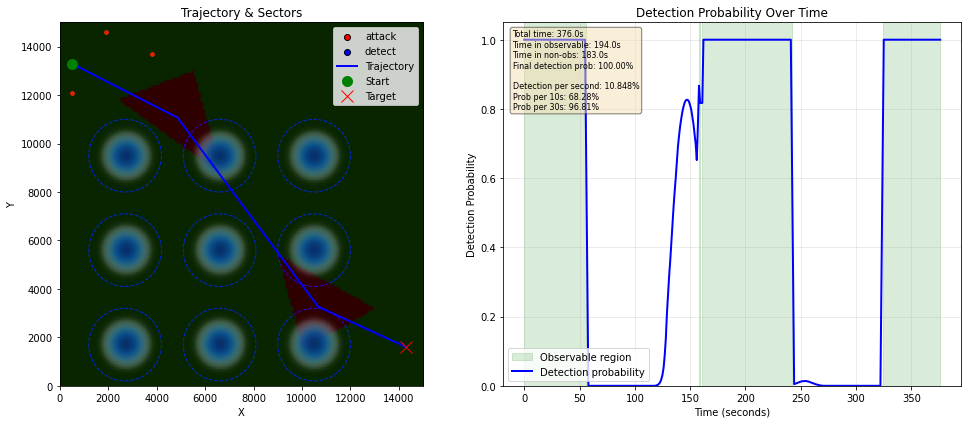


INCLUDING Observable Regions in Statistics


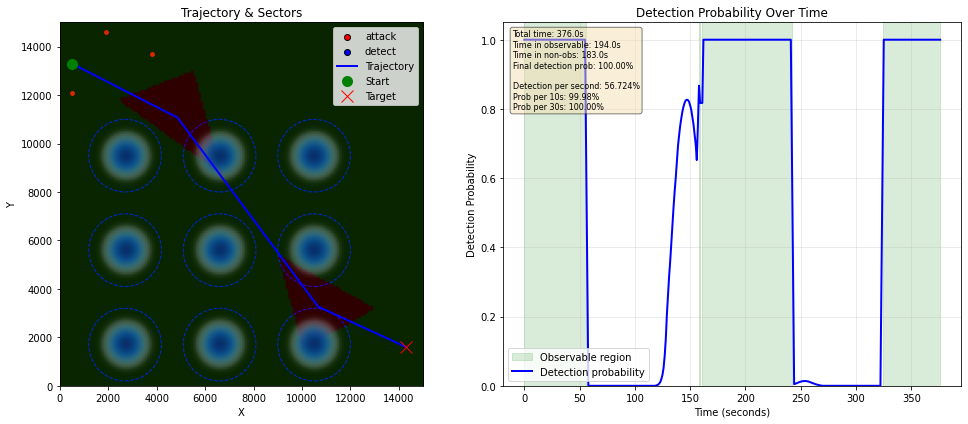

In [13]:
# Show both visualizations for comparison
if len(attackers) > 0:
    print("=" * 80)
    print("EXCLUDING Observable Regions from Statistics")
    print("=" * 80)
    sector_env.visualize_trajectory_analysis(
        attackers[0], 
        figsize=(14, 6),
        include_observable_in_stats=False
    )
    
    print("\n" + "=" * 80)
    print("INCLUDING Observable Regions in Statistics")
    print("=" * 80)
    sector_env.visualize_trajectory_analysis(
        attackers[0], 
        figsize=(14, 6),
        include_observable_in_stats=True
    )